In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from forcing_functions import get_function
from finite_element_code import set_up_4_dof, integrate_rk4, get_mck

# Set the random seed so that results are consistent across trials
torch.manual_seed(123)

# Creating The SIREN Class
The SIREN network is described in [this paper](https://arxiv.org/abs/2006.09661)

The main points from the paper that will be used here are:
- Neural networks are functions of the form $u(x) = l_N \circ l_{N-1} \circ \cdots \circ l_1$ 
  - Each $l_i$ is a function representing a layer of the network
  - $N$ is the number of layers in the network
  - The layers take the form $l_i(x) = a( W_i x + b_i )$
    - $a$ is the activation function (in this case $a(x) = \sin (\omega_0 x)$, where $\omega_0$ is a hyper-parameter)

SIRENs are especially good at handling differentiation of the network with respect to its input. This is because
$$\frac{d}{dx}\sin(x) = \cos(x) = \sin\left(\frac{\pi}{2}-x\right)$$

In [2]:
# Define the layers l_1 ... l_(N-1). l_N is just a linear layer, Wx + b
class SineLayer(nn.Module):
    """
    Adapted from
    https://github.com/vsitzmann/siren/blob/master/explore_siren.ipynb
    """

    def __init__(
        self, in_features, out_features, bias=True, is_first=False, omega_0=30
    ):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 1 / self.in_features)
            else:
                self.linear.weight.uniform_(
                    -np.sqrt(6 / self.in_features) / self.omega_0,
                    np.sqrt(6 / self.in_features) / self.omega_0,
                )

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))


# Define the SIREN network
class Siren(nn.Module):
    """
    Adapted from
    https://github.com/vsitzmann/siren/blob/master/explore_siren.ipynb
    """

    def __init__(
        self,
        in_features,
        hidden_features,
        hidden_layers,
        out_features,
        outermost_linear=False,
        first_omega_0=30,
        hidden_omega_0=30.0,
    ):
        super().__init__()

        self.net = []
        self.net.append(
            SineLayer(
                in_features, hidden_features, is_first=True, omega_0=first_omega_0
            )
        )

        for i in range(hidden_layers):
            self.net.append(
                SineLayer(
                    hidden_features,
                    hidden_features,
                    is_first=False,
                    omega_0=hidden_omega_0,
                )
            )

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(
                    -np.sqrt(6 / hidden_features) / hidden_omega_0,
                    np.sqrt(6 / hidden_features) / hidden_omega_0,
                )

            self.net.append(final_linear)
        else:
            self.net.append(
                SineLayer(
                    hidden_features,
                    out_features,
                    is_first=False,
                    omega_0=hidden_omega_0,
                )
            )

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = (
            coords.clone().detach().requires_grad_(True)
        )  # allows to take derivative w.r.t. input
        output = self.net(coords)

        return output, coords


class OtherActivationNetwork(nn.Module):
    # Same as Siren class, except the activation function can be chosen
    def __init__(
        self,
        in_features,
        hidden_features,
        hidden_layers,
        out_features,
        outermost_linear=False,
        activation=nn.Tanh,
    ):
        super().__init__()
        self.activation = activation

        self.net = []
        self.net.append(
            nn.Sequential(nn.Linear(in_features, hidden_features), self.activation())
        )

        for _ in range(hidden_layers):
            self.net.append(
                nn.Sequential(
                    nn.Linear(
                        hidden_features,
                        hidden_features,
                    ),
                    self.activation(),
                )
            )

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            self.net.append(final_linear)
        else:
            self.net.append(
                nn.Sequential(
                    nn.Linear(hidden_features, out_features), self.activation()
                )
            )

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = (
            coords.clone().detach().requires_grad_(True)
        )  # allows to take derivative w.r.t. input
        output = self.net(coords)

        return output, coords


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

# The Problem
A spring-mass system obeys the following second-order linear ordinary differential equation
$$M\ddot{\vec{u}} + C\dot{\vec{u}} + K\vec{u} = \vec{f}(t)$$
where $u(t)$ is the position of the mass along the axis of the spring and $f(t)$ is the force applied to the spring

We know that
$$ \begin{cases} \vec{u}(0) = \vec{0} \\ \dot{\vec{u}}(0) = \vec{0} \end{cases} $$


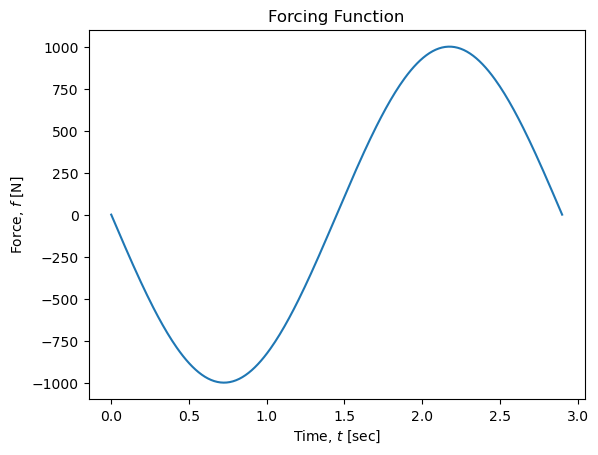

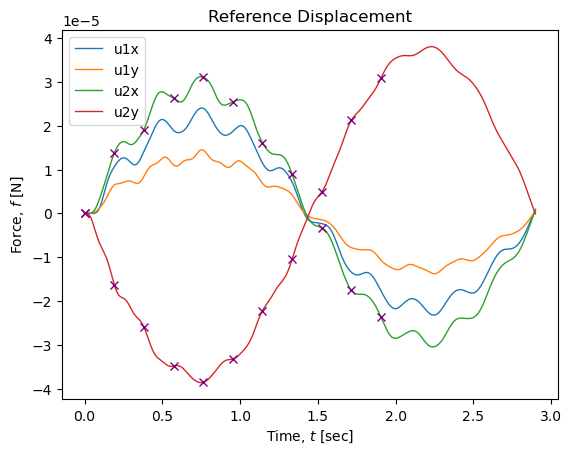

In [15]:
INITIAL_TIME = 0
FINAL_TIME = 2.9
N_TIMESTEPS = 290
N_DATAPOINTS = 10  # Can't be zero. If only initial conditions are desired, put 0.01
DOF_DATA = [2, 3]  # Which degrees of freedom to give data on
DATA_CUTOFF_TIME = 2
FUNCTION = "sine"

t = torch.linspace(INITIAL_TIME, FINAL_TIME, N_TIMESTEPS, device="cuda")

x, y, E, nu, rho, a0, a1, fdim, free_indices, ndim, sens_dim = set_up_4_dof()
ffun = get_function(FUNCTION, INITIAL_TIME, FINAL_TIME, amplitude=-1000, total_dimensions=ndim, force_dimension=fdim)
m, c, k = get_mck( x, y, E, nu, rho, a0, a1, free_indices, device="cuda")
displacements, velocities = integrate_rk4(m, c, k, ffun, t)

cutoff_index = torch.argmin( (t - DATA_CUTOFF_TIME).abs() )
data_indices = torch.arange( 0, cutoff_index, int(cutoff_index / N_DATAPOINTS) )

i, j = torch.meshgrid(torch.as_tensor(DOF_DATA), data_indices, indexing="ij")
displacement_data = displacements[i, j]
velocity_data = velocities[i, j]
t_data = t[data_indices]

plt.figure()
plt.title("Forcing Function")
plt.xlabel("Time, $t$ [sec]")
plt.ylabel("Force, $f$ [N]")
plt.plot(t.cpu(), ffun(t)[fdim, :].cpu())

plt.figure()
plt.title("Reference Displacement")
plt.xlabel("Time, $t$ [sec]")
plt.ylabel("Force, $f$ [N]")
plt.plot(t.cpu(), displacements.cpu().T, linewidth=1)
plt.plot(t_data.cpu(), displacement_data.cpu().T, linestyle="None", marker="x", color="purple")
plt.legend(["u1x", "u1y", "u2x", "u2y"])

# NN Definition 
<span style="color:yellow"> Christina - you can delete this part and the cell below it. This is for the central difference scheme. Go ahead and read over it though if you're interested. </span>

To obtain the solution function $\mathbf{u}$ using a neural network, a neural network prior, $\mathbf{\hat{u}^1}$, will be placed on the next _displacement_ as follows. Note that a hat ( $\hat{}$ ) denotes a value obtained from neural network predictions.

$$
\mathbf{u}^0, \mathbf{u}^{-1}, f_0 \rightarrow \boxed{\text{PINN}} \rightarrow \mathbf{\hat{u}^1}
$$

Velocity and acceleration may be computed via
$$
\mathbf{\hat{v}}^0 = \frac{1}{2\Delta t} \left(\mathbf{\hat{u}}^1 - \mathbf{u}^{-1}\right)
$$

$$
\mathbf{\hat{a}}^0 = \frac{1}{2\Delta t} \left( \mathbf{\hat{u}}^1 - 2\mathbf{u}^0 + \mathbf{u}^{-1} \right)
$$

The residual vector is then
$$
\mathbf{\hat{r}} = M\mathbf{\hat{a}}^0 + C\mathbf{\hat{v}}^0 + K\mathbf{u^0} - \mathbf{f}^0
$$

The physics loss is given by
$$
L_P = \mathbf{\hat{r}}^T\mathbf{\hat{r}}
$$

_Important:_ If $\mathbf{u}^{-1}$ is not available at a given time-step, it can be approximated from $\mathbf{u}^0$ and $\mathbf{u}^1$


# Visualize Neural Network Prediction